<a href="https://colab.research.google.com/github/vbvss199/colab_notebooks/blob/main/Part3_project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import PIL
import sklearn
import torch
import torchvision
import torch.onnx

from torchvision import transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image

In [ ]:
!pip install kaggle
!kaggle datasets download -d nitishabharathi/scene-classification
import zipfile

with zipfile.ZipFile('scene-classification.zip', 'r') as zip_ref:
    zip_ref.extractall('scene-classification')



Dataset URL: https://www.kaggle.com/datasets/nitishabharathi/scene-classification
License(s): CC0-1.0
 98% 352M/361M [00:02<00:00, 158MB/s]
100% 361M/361M [00:02<00:00, 146MB/s]


In [ ]:
from pathlib import Path
basePath = '/content/scene-classification/train-scene classification/'
resultPath = '/content/result/'
# adding a folder on kaggle to save models
Path(resultPath).mkdir(exist_ok=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
dataPath = basePath + 'train/'
modelPath = resultPath + 'model.pt'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform):
        self.dataframe = dataframe
        self.transform = transform

    def __getitem__(self,index):
        x = Image.open(dataPath + self.dataframe.iloc[index,0])
        x = self.transform(x)
        y = self.dataframe.iloc[index,1]
        return x,y

    def __len__(self):
        return self.dataframe.shape[0]

In [ ]:
# read file with image names and labels
df = pd.read_csv(basePath + 'train.csv')
# splitting the data into training and testing parts
Train, Validation = train_test_split(df, test_size=0.2, shuffle=True, random_state=5)
df.head()
print("Training set size:", len(Train))
print("Validation set size:", len(Validation))

Training set size: 13627
Validation set size: 3407


In [ ]:
# getting the best weights for the selected model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
# extract appropriate transformations to be applied to images
auto_transforms = weights.transforms()

In [ ]:
# split samples into batches of 64 for upcoming "mini-batch" passes
batch_size = 64
train_set = CustomDataset(Train, transform=auto_transforms)
val_set = CustomDataset(Validation, transform=auto_transforms)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set , batch_size=batch_size, shuffle=True)

print('Training set: {}, Validation set: {}'.format(Train.shape[0], Validation.shape[0]))

Training set: 13627, Validation set: 3407


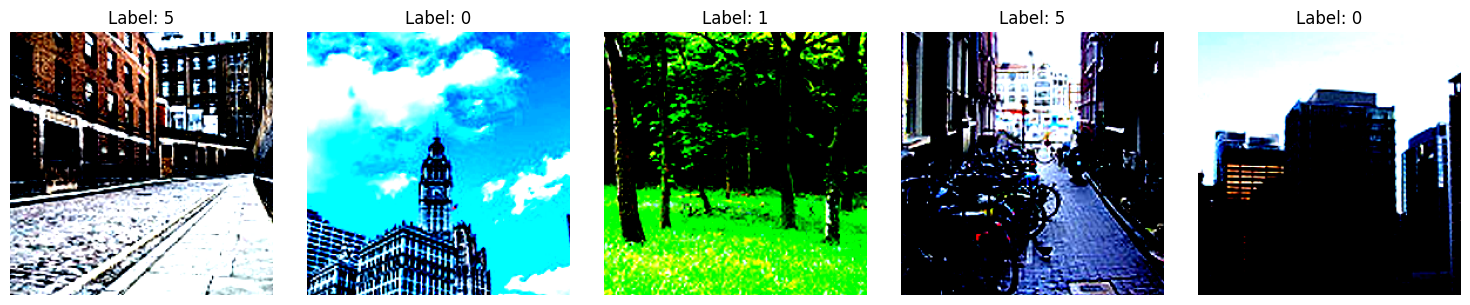

In [ ]:
import matplotlib.pyplot as plt

# Get the batch of examples
examples = next(iter(train_loader))

# examples[0] contains the images, examples[1] contains the labels
images, labels = examples

# Set up the plot with 1 row and 5 columns
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

# Loop through the first 5 images and display them
for i in range(5):
    img = images[i]
    axes[i].imshow(img.permute(1, 2, 0))  # Permute to (height, width, channels) for display
    axes[i].set_title(f"Label: {labels[i]}")
    axes[i].axis('off')  # Hide the axes

# Show the plot
plt.tight_layout()
plt.show()


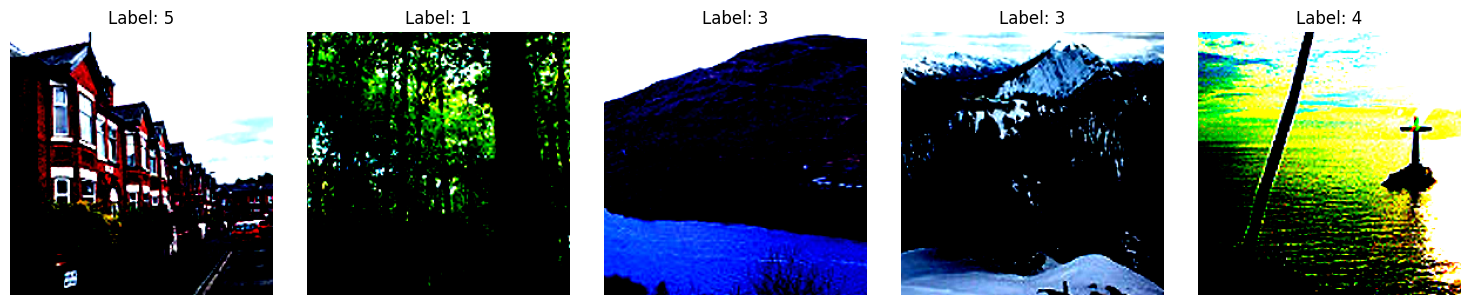

In [ ]:
import matplotlib.pyplot as plt

# Get the batch of examples
examples = next(iter(val_loader))

# examples[0] contains the images, examples[1] contains the labels
images, labels = examples

# Set up the plot with 1 row and 5 columns
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

# Loop through the first 5 images and display them
for i in range(5):
    img = images[i]
    axes[i].imshow(img.permute(1, 2, 0))  # Permute to (height, width, channels) for display
    axes[i].set_title(f"Label: {labels[i]}")
    axes[i].axis('off')  # Hide the axes

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
# Load pretrained ResNet18
model = models.resnet18(pretrained=True)


num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 6)

# AdamW optimizer and loss functions were used for training - categorical cross-entropy, which is the most suitable for the classification model
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
cost = torch.nn.CrossEntropyLoss()
epochs = 5

for epoch in range(epochs):
    train_loss = 0
    val_loss = 0
    train_correct = 0
    val_correct = 0

   # transfer the model to training mode
    model.train()
    for x, y in train_loader:
        optimizer.zero_grad()
        x,y = x.to(device),y.to(device)

       # calculate prediction and loss
        pred = model(x)
        loss = cost(pred, y)
        train_loss += cost(pred, y).item()
        train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

       # backpropagation
        loss.backward()
        optimizer.step()

   # switching the model to evaluation mode
    model.eval()
    with torch.no_grad():
        for x, y in val_loader:
            x,y = x.to(device),y.to(device)

            pred = model(x)
            loss = cost(pred, y)
            val_loss += cost(pred, y).item()
            val_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    train_loss = train_loss/len(train_loader)
    val_loss = val_loss/len(val_loader)
    train_accuracy = train_correct / len(Train)
    val_accuracy = val_correct / len(Validation)

    print("epoch = %d, train_loss = %.5f, val_loss = %.5f, train_accuracy = %.5f, val_accuracy = %.5f" % (epoch, train_loss, val_loss, train_accuracy, val_accuracy))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 59.6MB/s]


KeyboardInterrupt: 